In [ ]:
import json
from pathlib import Path

import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from tqdm import tqdm

In [2]:
metadata_path = Path("data/SUDACT_DATA_FULL.json")

with open(metadata_path) as meta_file:
    meta = json.loads(meta_file.read())

In [ ]:
doc2meta = {}  # create doc uid to metadata mapping

for docs_group in tqdm(meta):
    codex = docs_group["tags"][0][0]
    theme = docs_group["tags"][1]
    for doc_uid in docs_group["documents"]:
        if doc_uid not in doc2meta.keys():
            doc2meta[doc_uid] = {"codex": [codex], "theme": [theme]}
        else:
            doc2meta[doc_uid]["codex"].append(codex)
            doc2meta[doc_uid]["codex"] = sorted(list(set(doc2meta[doc_uid]["codex"])))
            doc2meta[doc_uid]["theme"].append(theme)
            doc2meta[doc_uid]["theme"] = sorted(list(set(doc2meta[doc_uid]["theme"])))

100%|██████████| 130/130 [00:00<00:00, 819.78it/s]


In [ ]:
with open("data/doc2meta.json", "w") as f:
    json.dump(doc2meta, f)

In [ ]:
!unzip data/OUTPUT_PARSE.zip data/

In [16]:
docs_path = Path("data/OUTPUT_PARSE")
docs_paths = list(docs_path.iterdir())
len(docs_paths)

51341

In [17]:
def parse_html(html: str) -> str:
    """
    Parse HTML doc to raw text. Also extract only data from <body> tags.

    Adds a new line for 'br',  'p', 'h1', 'h2', 'h3', 'h4','tr', 'th' tags
    and also a new line in front of text for li elements (bullet lists).
    """
    soup = BeautifulSoup(html, features="html.parser").body

    text = ""
    for e in soup.descendants:
        if isinstance(e, str):
            text += e.strip()
        elif e.name in ["br", "p", "h1", "h2", "h3", "h4", "tr", "th"]:
            text += "\n"
        elif e.name == "li":
            text += "\n- "
    return text

In [19]:
docs = {}
for doc_path in tqdm(docs_paths):
    with open(doc_path, "r") as f:
        html_doc = f.read()
    docs[doc_path.stem] = parse_html(html_doc)

len(docs)

100%|██████████| 51341/51341 [09:58<00:00, 85.77it/s] 


51341

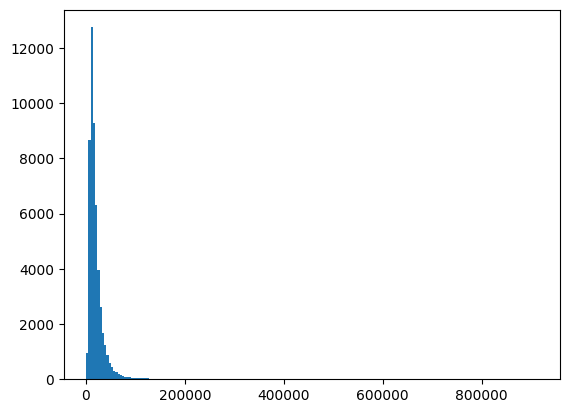

In [30]:
plt.hist([len(doc) for doc in docs.values()], bins=200);

In [31]:
# Drop long docs (in order to fit in context length of llm, used for summarization)
docs = {uid: doc for uid, doc in docs.items() if len(doc) < 35000}
len(docs)

45465

In [ ]:
# Save processed docs
processed_docs_path = Path("data/practice_processed/")
processed_docs_path.mkdir(exist_ok=True)

for uid, doc in tqdm(docs.items()):
    with open(processed_docs_path / f"{uid}.txt", "w") as f:
        f.write(doc)

100%|██████████| 45465/45465 [00:24<00:00, 1819.13it/s]
